<a href="https://colab.research.google.com/github/wangqy1216/Emotion-Prediction-in-the-Darkness/blob/master/Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple application to test facial expressions.

### Import packages and download models

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import IPython
import PIL
import pickle
import sklearn
from google.colab.patches import cv2_imshow

In [ ]:
!pip install ffmpeg-python

In [ ]:
# used for accessing url to download files
import urllib.request as urlreq

# save facial landmark detection model's url in LBFmodel_url variable
LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"

# save facial landmark detection model's name as LBFmodel
LBFmodel = "lbfmodel.yaml"

# save face detection algorithm's url in haarcascade_url variable
haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"

# save face detection algorithm's name as haarcascade
haarcascade = "haarcascade_frontalface_alt2.xml"

# download picture from url and save locally as lbfmodel.yaml, < 54MB
urlreq.urlretrieve(LBFmodel_url, LBFmodel)
print("File downloaded")

# download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
urlreq.urlretrieve(haarcascade_url, haarcascade)
print("File downloaded")

# create an instance of the Facial landmark Detector with the model
landmark_detector  = cv2.face.createFacemarkLBF()
landmark_detector.loadModel(LBFmodel)

# create an instance of the Face Detection Cascade Classifier
detector = cv2.CascadeClassifier(haarcascade)

File downloaded
File downloaded


### Load pretrained model

In [ ]:
# Please upload SVM.pkl

In [ ]:
# Load from file
with open('SVM.pkl', 'rb') as file:
    pickle_model = pickle.load(file)

### Retinex Theory

In [ ]:
# After comparison, Retinex Theory is much faster than my CycleGAN-based Model for dark image enhancement, 
# and the emotion prediction results dont't have evident difference

size = 3
scales = [3,5,9]

#Retinex algorithm
def replaceZeroes(data):
    min_nonzero = min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

def SSR(src_img, size):
    L_blur = cv2.GaussianBlur(src_img, (size, size), 0)
    img = replaceZeroes(src_img)
    L_blur = replaceZeroes(L_blur)

    dst_Img = cv2.log(img/255.0)
    dst_Lblur = cv2.log(L_blur/255.0)
    dst_IxL = cv2.multiply(dst_Img,dst_Lblur)
    log_R = cv2.subtract(dst_Img, dst_IxL)

    dst_R = cv2.normalize(log_R,None,0,255,cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8

def MSR(img, scales):
    weight = 1 / 3.0
    scales_size = len(scales)
    h, w = img.shape[:2]
    log_R = np.zeros((h, w), dtype=np.float32)

    for i in range(scales_size):
        img = replaceZeroes(img)
        L_blur = cv2.GaussianBlur(img, (scales[i], scales[i]), 0)
        L_blur = replaceZeroes(L_blur)
        dst_Img = cv2.log(img/255.0)
        dst_Lblur = cv2.log(L_blur/255.0)
        dst_Ixl = cv2.multiply(dst_Img, dst_Lblur)

        # print(dst_Img.shape)
        # print(dst_Ixl.shape)
        # print(log_R.shape)

        log_R += weight * cv2.subtract(dst_Img, dst_Ixl)

    dst_R = cv2.normalize(log_R, None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8

In [ ]:
import math

def feature_extractor(data):

  # horizental_norm_distance = math.sqrt( ((data[0][0] - data[16][0])**2) + ((data[0][1] - data[16][1])**2) )
  # vertical_norm_distance = math.sqrt( ((data[27][0] - data[8][0])**2) + ((data[27][1] - data[8][1])**2) )

  #Left eye center
  left_eye_center_x = (data[36][0] + data[39][0]) / 2
  left_eye_center_y = (data[36][1] + data[39][1]) / 2

  #Right eye center
  right_eye_center_x = (data[41][0] + data[45][0]) / 2
  right_eye_center_y = (data[41][1] + data[45][1]) / 2

  #Eye Center
  eyebrow_center_x = (left_eye_center_x + right_eye_center_x) / 2
  eyebrow_center_y = (left_eye_center_y + right_eye_center_y) / 2

  horizental_norm_distance = math.sqrt( ((left_eye_center_x - right_eye_center_x)**2) + ((left_eye_center_y - right_eye_center_y)**2) )
  vertical_norm_distance = math.sqrt( ((eyebrow_center_x - data[33][0])**2) + ((eyebrow_center_y - data[33][1])**2) )


  #Left Eyebrow Length
  left_eyebrow_length = math.sqrt( ((data[22][0] - data[26][0])**2) + ((data[22][1] - data[26][1])**2) )
  #Right Eyebrow Length
  right_eyebrow_length = math.sqrt( ((data[17][0] - data[21][0])**2) + ((data[17][1] - data[21][1])**2) )

  #Left Outer Eyebrow Height
  left_outer_eyebrow_height = math.sqrt( ((data[24][0] - (data[42][0] + data[45][0]) / 2)**2) + ((data[24][1] - (data[42][1] + data[45][1]) / 2)**2) )
  #Right Outer Eyebrow Height
  right_outer_eyebrow_height = math.sqrt( ((data[19][0] - (data[36][0] + data[39][0]) / 2)**2) + ((data[19][1] - (data[36][1] + data[39][1]) / 2)**2) )

  #Left Inner Eyebrow Height
  left_inner_eyebrow_height = math.sqrt( ((data[22][0] - data[42][0])**2) + ((data[22][1] - data[42][1])**2) )
  #Right Inner Eyebrow Height
  right_inner_eyebrow_height = math.sqrt( ((data[21][0] - data[39][0])**2) + ((data[21][1] - data[39][1])**2) )

  #Left Eye Height
  left_eye_height = math.sqrt( ((data[43][0] - data[47][0])**2) + ((data[43][1] - data[47][1])**2) ) + math.sqrt( ((data[44][0] - data[46][0])**2) + ((data[44][1] - data[46][1])**2) )
  #Right Eye Height
  right_eye_height = math.sqrt( ((data[38][0] - data[40][0])**2) + ((data[38][1] - data[40][1])**2) ) + math.sqrt( ((data[37][0] - data[41][0])**2) + ((data[37][1] - data[41][1])**2) )

  #Mouth Height
  mouth_height = math.sqrt( ((data[62][0] - data[66][0])**2) + ((data[62][1] - data[66][1])**2) )

  #Mouth Width
  mouth_width = math.sqrt( ((data[48][0] - data[54][0])**2) + ((data[48][1] - data[54][1])**2) )

  #Left Lip Height
  left_lip_height = math.sqrt( ((data[47][0] - data[54][0])**2) + ((data[47][1] - data[54][1])**2) )

  #Right Lip Height
  right_lip_height = math.sqrt( ((data[48][0] - data[40][0])**2) + ((data[48][1] - data[40][1])**2) )

  #Upper Lip Height
  upper_lip_height = math.sqrt( ((data[51][0] - data[33][0])**2) + ((data[51][1] - data[33][1])**2) )

  #Jaw Height
  jaw_height = math.sqrt( ((data[8][0] - data[33][0])**2) + ((data[8][1] - data[33][1])**2) )

  return [
          left_eyebrow_length / horizental_norm_distance, 
          right_eyebrow_length / horizental_norm_distance, 
          left_outer_eyebrow_height / vertical_norm_distance, 
          right_outer_eyebrow_height / vertical_norm_distance, 
          left_inner_eyebrow_height / vertical_norm_distance, 
          right_inner_eyebrow_height / vertical_norm_distance, 
          left_eye_height / vertical_norm_distance, 
          right_eye_height / vertical_norm_distance, 
          mouth_height / vertical_norm_distance, 
          mouth_width / horizental_norm_distance, 
          left_lip_height / vertical_norm_distance, 
          right_lip_height / vertical_norm_distance, 
          upper_lip_height / vertical_norm_distance, 
          jaw_height / vertical_norm_distance
          ]

In [ ]:
# Take photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.style.width = '50%';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);
      
      // wait 1000 ms and resolve
      await new Promise(resolve => setTimeout(resolve, 200));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      //setTimeout(function(){ x.value = "100 seconds" }, 1000000000);

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
color = (0, 0, 255)

try:
  while(1):
    filename = take_photo()
    #print('Saved to {}'.format(filename))

    frame = cv2.imread('photo.jpg')
    b_gray, g_gray, r_gray = cv2.split(frame)
    b_gray = MSR(b_gray, scales)
    g_gray = MSR(g_gray, scales)
    r_gray = MSR(r_gray, scales)
    new_frame = cv2.merge([b_gray, g_gray, r_gray]) 

    # new_frame = frame
    #new_frame = SSR(frame, 3)

    gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(gray)

    if len(faces) != 0:
      # Detect landmarks on "image_gray"
      _, landmarks = landmark_detector.fit(gray, faces)

      if len(landmarks) != 0:
        for landmark in landmarks:
          for x,y in landmark[0]:
              cv2.circle(new_frame, (x, y), 3, color, 2)
              cv2.circle(frame, (x, y), 3, color, 2)

      prediction = pickle_model.predict([feature_extractor(landmark[0])])
      (x, y, w, h) = faces[0] 
      cv2.rectangle(new_frame, (x, y), (x + w, y + h), color , 2)
      cv2.rectangle(frame, (x, y), (x + w, y + h), color , 2)


      # center_y = (int)(x + w / 2)
      # center_x = (int)(y + w / 3)

      # b, g, r = new_frame[center_x][center_y][0], new_frame[center_x][center_y][1], new_frame[center_x][center_y][2]
      
      
      # if r > 95 and g > 40 and b > 20:
      if prediction[0] == 0:
        cv2.putText(new_frame, "Afraid", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 1:
        cv2.putText(new_frame, "Angry", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 2:
        cv2.putText(new_frame, "Disgusted", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 3:
        cv2.putText(new_frame, "Happy", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 4:
        cv2.putText(new_frame, "Neutral", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 5:
        cv2.putText(new_frame, "Sad", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)
      if prediction[0] == 6:
        cv2.putText(new_frame, "Surprised", (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 3, color , 2)

    images_horizontal = np.hstack((frame, new_frame))
    cv2_imshow(images_horizontal)

    # Show the image which was just taken.
    # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

KeyboardInterrupt: ignored

## Scripts
### This part is to add edge detection to help correct facial landmarks.

In [ ]:
# import the necessary packages
from collections import OrderedDict

FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

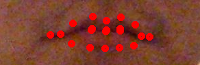

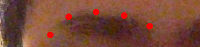

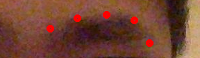

In [ ]:
import imutils

# frame = cv2.imread('photo.jpg')
# b_gray, g_gray, r_gray = cv2.split(frame)
# b_gray = MSR(b_gray, scales)
# g_gray = MSR(g_gray, scales)
# r_gray = MSR(r_gray, scales)
# new_frame = cv2.merge([b_gray, g_gray, r_gray]) 
frame = cv2.imread('photo.jpg')
new_frame = frame

gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

# Detect faces using the haarcascade classifier on the "grayscale image"
faces = detector.detectMultiScale(gray)

counter = 0
if len(faces) != 0:
    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(gray, faces)

    points = landmarks[0][0]

    prediction = pickle_model.predict([feature_extractor(landmark[0])])
    (x, y, w, h) = faces[0] 
    
    # loop over the face parts individually
    for (name, (i, j)) in FACIAL_LANDMARKS_68_IDXS.items():
        clone = new_frame.copy()
        cv2.putText(clone, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
          3, (0, 0, 255), 3)
        for (x, y) in points[i:j]:
            cv2.circle(clone, (x, y), 3, (0, 0, 255), 3)
      
        # extract the ROI of the face region as a separate image
        (x, y, w, h) = cv2.boundingRect(np.array([points[i:j]]))
        region = clone[y - int(h / 2) : y + h + int(h/2), x - int(w/2) : x + w + int(w/2)]
        region = imutils.resize(region, width=200, inter=cv2.INTER_CUBIC)
        # show the particular face part
        cv2_imshow(region)
        counter += 1
        if counter == 4:
          break;

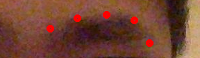

In [ ]:
cv2_imshow(region)

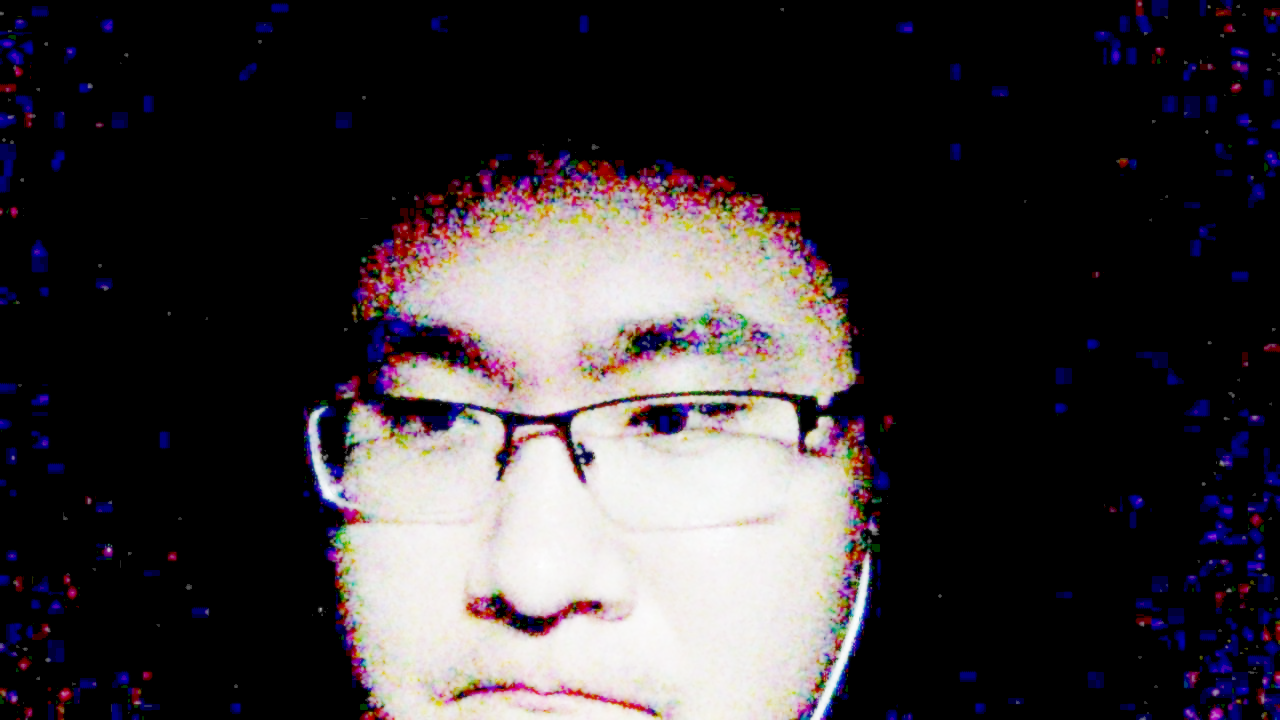

In [ ]:
cv2_imshow(new_frame)

In [ ]:
from sklearn.cluster import KMeans

region = new_frame[y - int(h / 2) : y + h + int(h/2), x - int(w/2) : x + w + int(w/2)]

# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = region.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [ ]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
# number of clusters (K)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [ ]:
# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(region.shape)

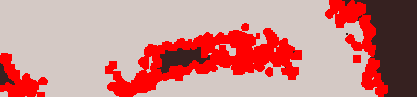

In [ ]:
cv2_imshow(segmented_image)

In [ ]:
segmented_image = segmented_image.astype(np.uint8)

edges = cv2.Canny(new_frame,100,200)

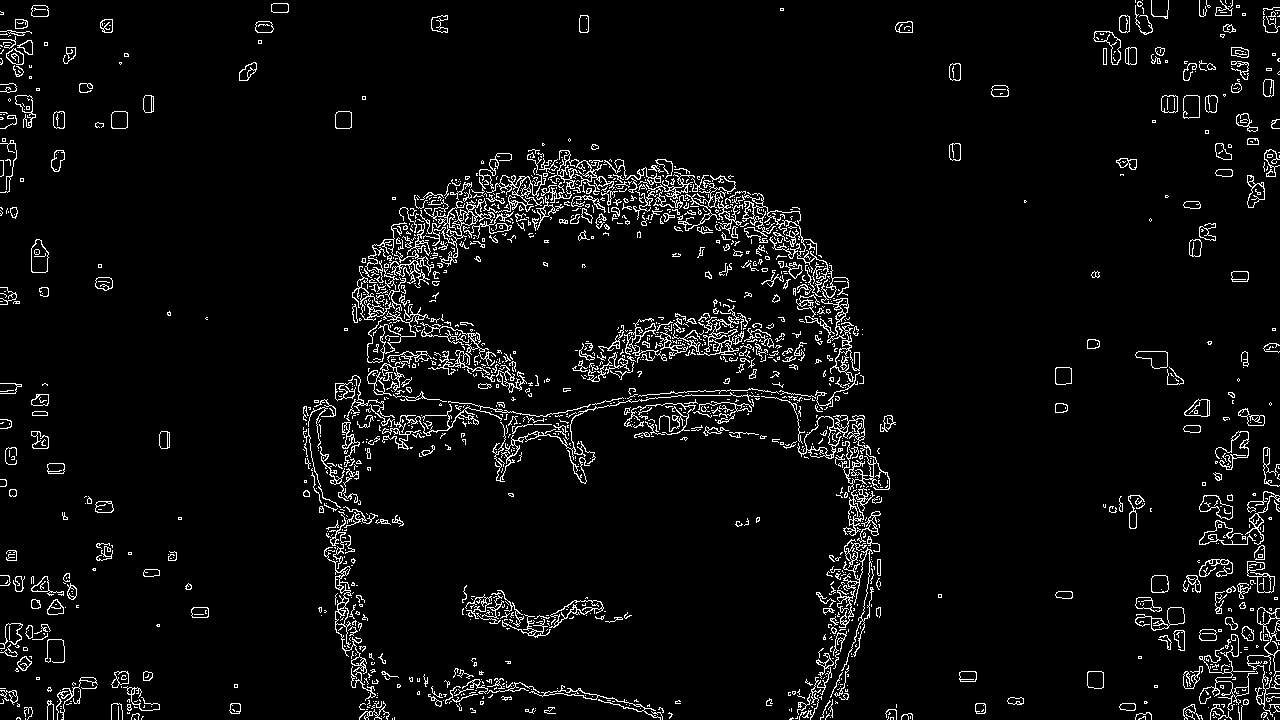

In [ ]:
cv2_imshow(edges)

In [ ]:
img = cv2.imread('eyebrow.jpg')

Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

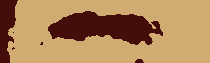

In [ ]:
cv2_imshow(res2)

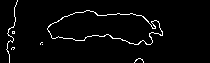

In [ ]:
cv2_imshow(edges)

In [ ]:
pixels_list = []

for i in range(len(edges)):
  for j in range(len(edges[0])):
    if edges[i][j] == 255:
      pixels_list.append([i, j])

In [ ]:
for ele in pixels_list:
  # cv2.circle(res2, (ele[1], ele[0]), 2, (255,0,0), -1)
  cv2.circle(res2, (ele[1], ele[0]), 1, color, -1)

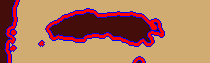

In [ ]:
cv2_imshow(res2)

In [ ]:
cv2.imwrite('oup.jpg', res2)

True

In [ ]:
def get_hog() : 
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog

In [ ]:
import cv2
hog = get_hog()

im = cv2.imread('photo.jpg')
h = hog.compute(im)

In [ ]:
h.shape

(43375500, 1)

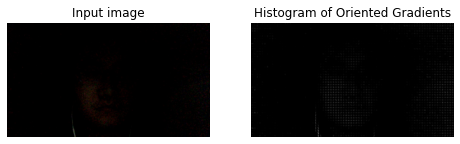

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = plt.imread('photo.jpg')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()